# 定义问题

根据之前的每日激活数字预测未来激活趋势

在线notebook：https://www.kaggle.com/code/abrahamcheng/rnn-network

# 数据预处理

## 导入数据

In [1]:
import numpy as np #导入NumPy
import pandas as pd #导入Pandas 
df_app = pd.read_csv('../input/flower-app/App.csv', index_col='Date', parse_dates=['Date']) #导入数据
df_app #显示数据

,Activation
Date,
2019-01-01,419
2019-01-02,432
2019-01-03,436
2019-01-04,439
2019-01-05,439
...,...
2021-01-21,916
2021-01-22,925
2021-01-23,926


## 数据可视化


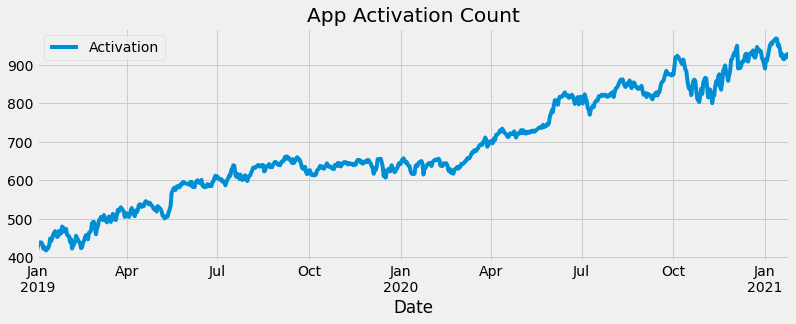

In [2]:
import matplotlib.pyplot as plt #导入matplotlib.pyplot
plt.style.use('fivethirtyeight') #设定绘图风格
df_app["Activation"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('App Activation Count') #图题
plt.show() #绘图

这段代码使用 `matplotlib.pyplot` 库来绘制一个包含花卉应用激活次数的图表。

1. 首先，导入 `matplotlib.pyplot` 库并命名为 `plt`。

2. 设定绘图风格为 `fivethirtyeight`，这是一个流行的预设绘图风格，具有较高的清晰度和视觉吸引力。

3. 使用 `df_app["Activation"].plot()` 函数对应用激活次数（`df_app` 是包含激活次数数据的数据框，而“Activation”是相应的列名）绘制折线图。`figsize=(12,4)` 设置图像大小，`legend=True` 表示在图中显示图例。

4. 通过 `plt.title()` 函数，设置图形的标题为 'App Activation Count'。

5. 最后，调用 `plt.show()` 函数来显示图形。这个图形可以帮助你了解应用激活次数随时间的变化趋势，以便对数据进行进一步分析。

## 拆分数据集

In [3]:
# 按照2020年10月1日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values #训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values #测试集

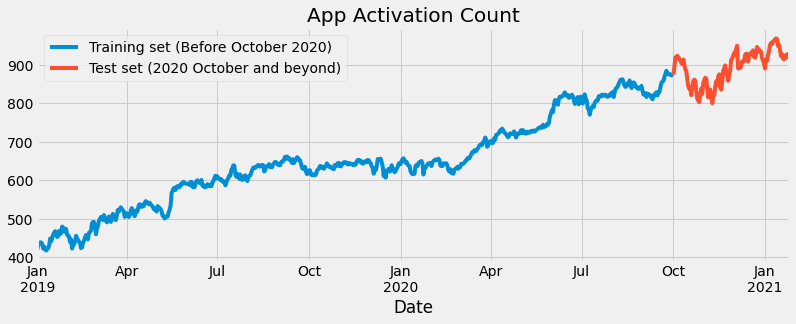

In [4]:
# 以不同颜色为训练集和测试集绘图
df_app["Activation"][:'2020-09-30'].plot(figsize=(12,4),legend=True) #训练集
df_app["Activation"]['2020-10-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)']) #图例
plt.title('App Activation Count') #图题
plt.show() #绘图

这段代码使用 `matplotlib.pyplot` 库在同一图表上绘制了应用激活次数数据的训练集和测试集部分。同时，训练集和测试集以不同颜色表示，便于区分。

以下是这段代码的详细解释：

1. 使用 `df_app["Activation"][:'2020-09-30'].plot()` 函数绘制训练集部分的折线图，表示从数据开始日期到 2020 年 9 月 30 日的应用激活次数。`figsize=(12,4)` 设置图像大小，`legend=True` 在图中显示图例。

2. 使用 `df_app["Activation"]['2020-10-01':].plot()` 函数绘制测试集部分的折线图，表示从 2020 年 10 月 1 日至数据结束日期的应用激活次数。

3. 通过 `plt.legend()` 函数设置图例标签，这里使用两个标签：'Training set (Before October 2020)' 表示训练集（2020 年 10 月之前的数据），'Test set (2020 October and beyond)' 表示测试集（2020 年 10 月及以后的数据）。

4. 使用 `plt.title()` 函数设置图形标题为 'App Activation Count'。

5. 最后，调用 `plt.show()` 函数显示图形。通过这个图形不仅可以了解应用激活次数随时间的变化趋势，还可以观察训练集和测试集在图表中的不同部分。这有助于理解模型是如何基于训练集数据进行学习以预测测试集数据的。

# 特征工程

In [5]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

这段代码先导入了 `MinMaxScaler`，这是一个用于数据归一化处理的工具，它可以将数据缩放到给定的范围内。归一化是数据预处理中的一个常见步骤，通过这一处理，我们可以让不同特征之间的取值范围统一，有助于模型的训练和收敛。

然后，我们创建了一个名为 `Scaler` 的 `MinMaxScaler` 对象。在创建这个对象时，参数 `feature_range=(0,1)` 表示我们希望将数据缩放到 0 到 1 之间。

接下来，我们使用 `Scaler.fit_transform(Train)` 对训练集 `Train` 进行拟合和归一化处理。拟合（fit）的过程是为了让缩放器学习训练数据的最大值、最小值等统计信息，从而确定具体的缩放规则。归一化（transform）的过程则是将这个缩放规则应用到训练集上，把训练数据的每个特征都压缩到 0 到 1 的范围内。在这个过程中，`Scaler` 对象会记录训练集的最大值、最小值等统计信息，这些信息稍后会用于对测试集进行相同的归一化处理。

## 构建特征集和标签集

In [6]:
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 训练集
X_train = [] #初始化
y_train = [] #初始化
for i in range(60,Train.size): 
    X_train.append(Train[i-60:i,0]) #构建特征
    y_train.append(Train[i,0]) #构建标签
X_train, y_train = np.array(X_train), np.array(y_train) #转换为NumPy数组
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #转换成神经网络所需的张量形状

In [7]:
TrainTest = df_app["Activation"][:] #整体数据
inputs = TrainTest[len(TrainTest)-len(Test) - 60:].values #Test加上前60个时间步
inputs = inputs.reshape(-1,1) #转换形状
inputs  = Scaler.transform(inputs) #归一化
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 测试集
X_test = [] #初始化
y_test = [] #初始化
for i in range(60,inputs.size): 
    X_test.append(inputs[i-60:i,0]) #构建特征
    y_test.append(inputs[i,0]) #构建标签
X_test = np.array(X_test) #转换为NumPy数组
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

这段代码用于构建用于训练神经网络模型的输入特征（X_train）和输出标签（y_train）。我们的目标是根据过去 60 个时间步长的数据来预测下一个时间步长的数据。

1. 我们首先创建了两个空列表，`X_train` 和 `y_train`，用于存放特征和标签。
2. 接着，我们遍历 `Train` 数据中的元素。`Train.size` 表示训练集的元素个数。我们从第 60 个元素开始遍历，直到数据末尾。这是因为我们需要使用前 60 个元素来构建第一个输入特征。
3. 在每次迭代中，我们选取 `i-60` 到 `i` 之间的数据作为特征（即过去的 60 个时间步长），并将第 `i` 个数据作为对应的标签（即要预测的下一个时间步长）。将这些数据分别添加到 `X_train` 和 `y_train` 列表中。
4. 将列表 `X_train` 和 `y_train` 转换为 NumPy 数组，便于后续处理和运算。
5. 最后，我们使用 `np.reshape()` 函数将 `X_train` 转换成神经网络所需的张量形状。神经网络需要的输入张量形状为 (样本数, 时间步长, 特征数)。这里，样本数为 `X_train.shape[0]`，时间步长为 `X_train.shape[1]`，特征数为 1（因为我们只有一个特征，即历史时间步长的数据）。

此时，我们得到了一个适合训练神经网络模型的数据集，每个样本包含 60 个时间步长的输入特征和对应的 1 个输出标签。

# 训练模型

这里我们采用RNN神经网络算法

In [8]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM #导入全连接层和LSTM层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
# RNN_LSTM.compile(loss='mean_squared_error', #损失函数
#                  optimizer='rmsprop', #优化器
#                  metrics=['mae']) #评估指标
RNN_LSTM.compile(loss='mse', #损失函数
                 optimizer='rmsprop', #优化器
                 metrics=['mae']) #评估指标
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


这段代码创建了一个使用长短时记忆（LSTM）神经网络的回归模型。LSTM 是一种特殊的循环神经网络（RNN），它能够捕捉长期时间序列数据中的依赖关系。

1. 首先，从 `tensorflow.keras.models` 和 `tensorflow.keras.layers` 分别导入 `Sequential`（序贯模型）类和 `Dense`（全连接层）、`LSTM`（长短时记忆层）类。

2. 接下来，我们创建一个 `Sequential` 类的实例 `RNN_LSTM`，建立一个序贯模型。

3. 为了构建 LSTM 网络架构，我们在模型中添加了四个 LSTM 层以及一个输出全连接层 `Dense`。在前三个 LSTM 层中，我们设置参数 `return_sequences=True`，这表示这些层会返回整个输出序列，而不仅仅是最后一个时间步的输出。这样做的原因是，我们希望这些 LSTM 层的输出在时间轴上传递到后续的 LSTM 层。

   第一个 LSTM 层接收形状为 `(X_train.shape[1], 1)` 的输入数据，即 60 个时间步长和 1 个特征。`units=50` 表示输出 50 个 LSTM 单元，即隐藏层的宽度。

4. 紧接着在模型中加入全连接输出层 `Dense`，设置 `units=1` 表示我们的输出层将只有一个输出值。

5. 编译模型：使用 `mse` (均方误差) 作为损失函数，`rmsprop` 优化器用于调整模型权重以最小化损失，以及 `mae` (平均绝对误差) 作为模型评估指标。

6. 最后，我们使用 `RNN_LSTM.summary()` 函数输出模型的结构信息。此时，我们已经成功构建了一个 LSTM 神经网络模型，可以用于训练和预测时间序列数据。

In [9]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/30
8/8 [==============================] - 10s 462ms/step - loss: 0.1130 - mae: 0.2774 - val_loss: 0.0563 - val_mae: 0.2329
Epoch 2/30
8/8 [==============================] - 1s 148ms/step - loss: 0.0037 - mae: 0.0474 - val_loss: 0.0550 - val_mae: 0.2301
Epoch 3/30
8/8 [==============================] - 1s 143ms/step - loss: 0.0044 - mae: 0.0526 - val_loss: 0.1650 - val_mae: 0.4037
Epoch 4/30
8/8 [==============================] - 1s 151ms/step - loss: 0.0129 - mae: 0.0854 - val_loss: 0.0102 - val_mae: 0.0905
Epoch 5/30
8/8 [==============================] - 1s 148ms/step - loss: 0.0081 - mae: 0.0754 - val_loss: 0.0112 - val_mae: 0.0956
Epoch 6/30
8/8 [==============================] - 1s 146ms/step - loss: 0.0039 - mae: 0.0497 - val_loss: 0.0129 - val_mae: 0.1042
Epoch 7/30
8/8 [==============================] - 1s 150ms/step - loss: 0.0031 - mae: 0.0430 - val_loss: 0.0027 - val_mae: 0.0419
Epoch 8/30
8/8 [==============================] - 1s 146ms/step - loss: 0.0102 - mae: 0.0

这段代码使用上面创建的 LSTM 神经网络模型对数据进行训练，并保存训练过程中的历史信息。

1. `history` 变量保存训练过程中的历史信息，供后续分析模型性能时使用。
2. 使用 `RNN_LSTM.fit()` 函数对模型进行训练。需要传入以下参数：
    - `X_train` 和 `y_train` 作为训练集的输入特征和输出标签。
    - `epochs` 参数用于指定训练的轮次。设置为 30，表示神经网络将遍历整个训练数据集 30 次。
    - `batch_size` 参数指定数据批量的大小。设置为 64，表示在每次反向传播之前，将使用 64 个数据样本进行一次前向传播。
    - `validation_split` 参数表示从训练集中拆分出来的验证集所占的比例。设置为 0.2，意味着我们将从原始训练数据集中抽取 20% 作为验证集，训练集和验证集的数据不会重叠。在训练过程中，我们会同时评估训练集和验证集的性能，以便对模型进行调优。

执行这段代码后，模型会在规定的轮次内进行训练。在每轮训练结束后，我们可以看到模型在训练集和验证集上的损失（loss）和评估指标（如：平均绝对误差, mae）。得到的 `history` 变量可以用于分析训练过程中模型性能的变化，有助于我们了解模型收敛情况以及是否存在过拟合等问题。

# 评估模型

In [10]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图

这个函数 `show_history` 用于绘制训练过程中的学习曲线，它接收一个参数 `history`，即之前训练模型时保存的历史信息。

1. 从 `history` 中提取训练损失 `loss` 和验证损失 `val_loss`，它们分别代表模型在训练集和验证集上的损失值。

2. 计算训练的轮次 `epochs`，即训练过程中每轮的序号。

3. 使用 `matplotlib` 绘制训练损失和验证损失随训练轮次变化的曲线。`plt.plot()` 函数用于绘制曲线。在这里，我们用蓝点实线表示训练损失，用蓝色实线表示验证损失。

4. 设置图标题、X 轴标签、Y轴标签以及图例。`plt.title()` 设置图标题，`plt.xlabel()` 和 `plt.ylabel()` 设置 X 轴和 Y 轴标签，`plt.legend()` 显示图例。

5. 调用 `plt.show()` 函数来显示学习曲线图。通过观察曲线图，我们可以评估模型在训练过程中的性能，例如损失下降速度，训练损失与验证损失之间是否有较大的差距，以及是否出现过拟合等现象。该图有助于我们进一步优化模型参数。

要使用这个函数呈现之前训练过程中的学习曲线，只需调用：
```python
show_history(history)
```

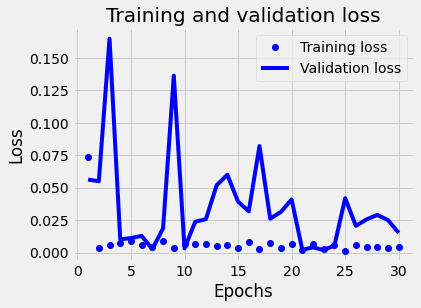

In [11]:
show_history(history) # 调用绘图函数

In [12]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('Flower App Activation Prediction') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('Flower App Activation Count') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

这个 `plot_predictions` 函数用于绘制模型预测结果与真实结果之间的比较图。它接收两个参数：

- `test`：表示实际观测值，通常是我们的测试数据集或验证数据集的目标变量（在这个例子中是花卉应用的真实激活次数）。
- `predicted`：表示由模型预测的值（在这个例子中是预测的花卉应用的激活次数）。

以下是函数的细节解释：

1. 使用 `plt.plot()` 函数分别绘制真实值和预测值曲线。这里，我们用红色线表示真实值，蓝色线表示预测值。

2. 设置图标题、X 轴标签、Y轴标签以及图例。`plt.title()` 设置图标题，`plt.xlabel()` 和 `plt.ylabel()` 设置 X 轴和 Y 轴标签，`plt.legend()` 显示图例。

3. 调用 `plt.show()` 函数来显示真实值与预测值的对比图。通过观察该图，我们可以直观地了解模型预测的准确性，分析可能存在的预测偏差，并做进一步优化。

要使用这个函数绘制真实值与预测值的对比图，你需要首先使用训练好的 LSTM 模型对测试数据集（或验证数据集）进行预测，然后传入真实值和预测值作为参数调用该函数：

```python
predictions = RNN_LSTM.predict(X_test)  # 使用 LSTM 模型预测测试数据集的激活次数
plot_predictions(y_test, predictions)   # 显示真实值与预测值的对比图
```

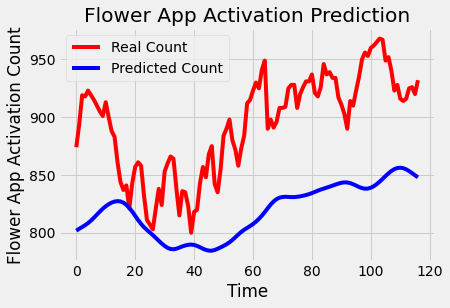

In [13]:
Pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(Pred) #反归一化
plot_predictions(Test,Pred) #绘图